In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
import kvn
colors_ = ["blue", "red", "green", "gray", "black"]
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
path_save_ = "./jupyter-notebooks/NL/results/"

18518
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [33]:
# -----------------------------------------------------------
# --- LCHS parameters ---
# get_Rc_angles
# -----------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

# --- rr is computed by comparing simulations with and without AA ---
k_max_, nk_, beta_,   rr_, sign_ = 10.0, 5, 0.7,   4.987032727149e+00, -1
k_max_, nk_, beta_,   rr_, sign_ = 10.0, 9, 0.7,   2.024974348049e+01, -1
k_max_, nk_, beta_,   rr_, sign_ = 100.0, 9, 0.7,  1.980775248126e+01, -1

Nk_ = 1 << nk_
dk_ = 2.* k_max_ / (Nk_ - 1)

arr_theta_ = np.linspace(-np.pi/2., np.pi/2., Nk_)
d_theta_ = np.diff(arr_theta_)[0]
k_ = k_max_ * np.sin(arr_theta_)

print("nk:\t {:d}".format(nk_))
print("dk:\t {:0.12e}".format(dk_))
print("kmax\t {:0.12f}".format(k_max_))
print("beta\t {:0.3f}".format(beta_))

# --- get LCHS weights ---
w_sqrt_ = kvn.comp_LCHS_weights_OPT(k_max_, Nk_, beta_)
w_sqrt_ = np.sqrt(w_sqrt_)

nk:	 9
dk:	 3.913894324853e-01
kmax	 100.000000000000
beta	 0.700


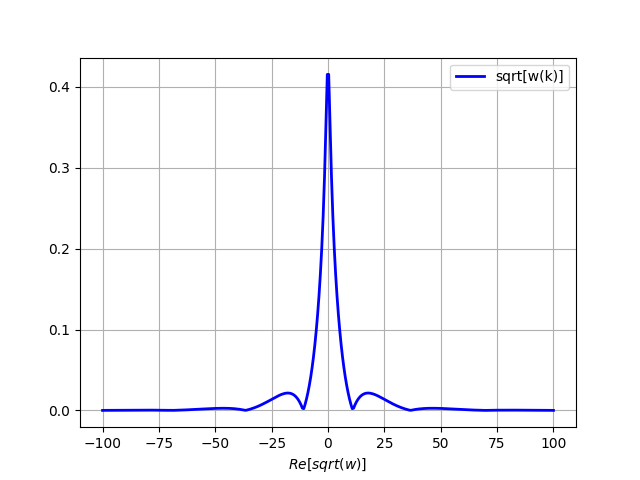

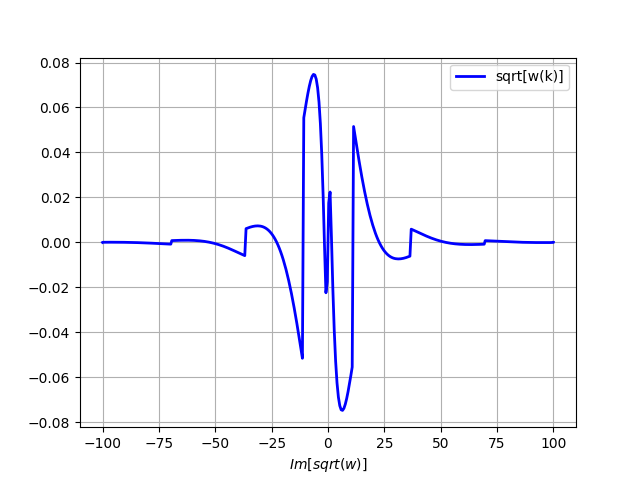

In [28]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)
def plot_weights(flag_save):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k_, w_sqrt_.real, 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    plt.xlabel('$x$')
    plt.xlabel('$Re[sqrt(w)]$')
    ax.legend()
    plt.grid(True)
    plt.show()


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k_, w_sqrt_.imag, 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    plt.xlabel('$x$')
    plt.xlabel('$Im[sqrt(w)]$')
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # --- Save the data ---
    if flag_save:  
        fname = "weights_sqrt_profs_k{:d}_b{:0.2f}".format(k_max_, beta_)     
        full_name = path_save_ + "/" + fname + "_RE.dat"
        mix.save_dat_plot_1d_file(full_name, arr_theta_, w_sqrt_.real)

        full_name = path_save_ + "/" + fname + "_IM.dat"
        mix.save_dat_plot_1d_file(full_name, arr_theta_, w_sqrt_.imag)
    return
# ------------------------------------------------------------
plot_weights(flag_save = False)

Reading the file ../QuCF/simulations/LCHS/weights-OPT//test_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  09-17-2024 19:22:01


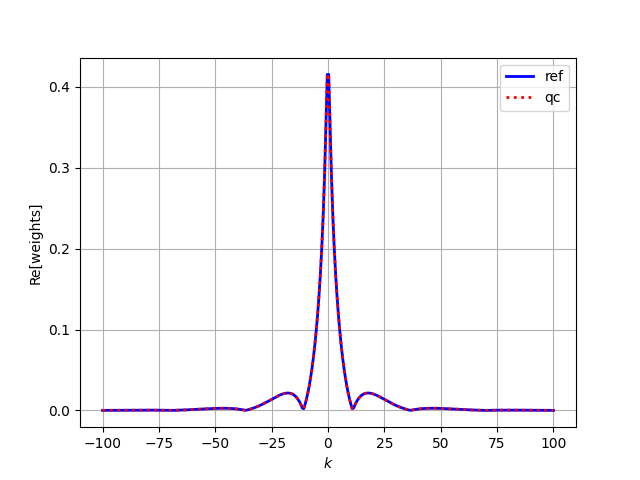

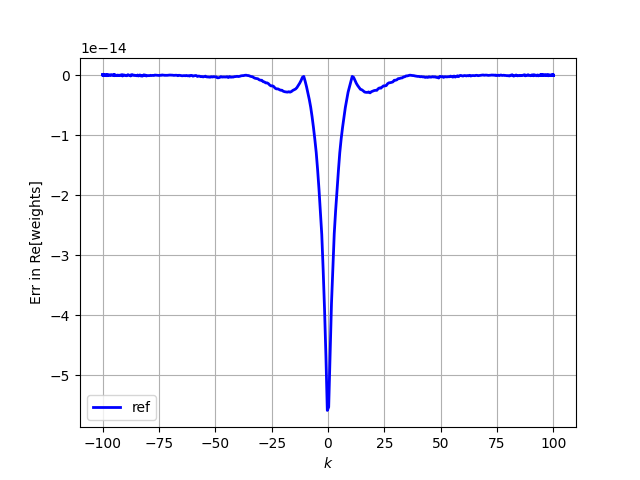

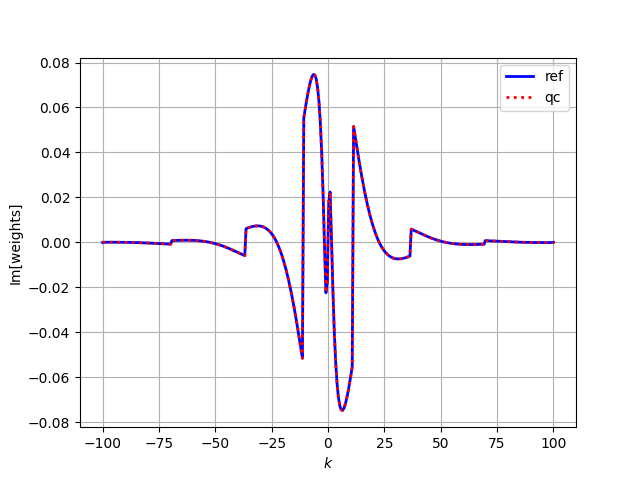

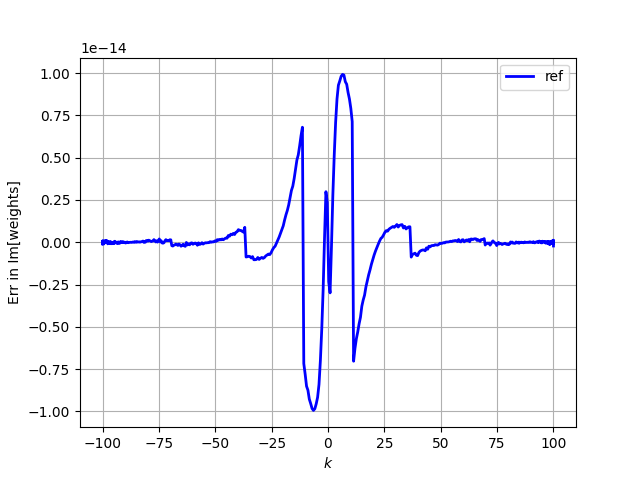


A-max (before renorm.): 3.640610080762e-01
success prob. (before renorm.): 9.999739147825e-01

N-gates: 16243


In [34]:
# -----------------------------------------------------------------
# --- QuCF computation of the LCHS weights ---
# -----------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

# ----------------------------------------------------------------------
# --- QuCF computation of the LCHS weights computed by QSVT ---
# ----------------------------------------------------------------------
def QuCF_direct(flag_AA):
    # set flag_AA = True, when AA is included in QuCF simulations and when rr has been found
    
    y_ref = np.array(w_sqrt_)

    Hadamart_norm_factor = 2**(nk_/2)

    # --- QuCF data ---
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/simulations/LCHS/weights-OPT/"
    om.pname_ = "test"
    om.open()
    Ngates = om.dd_["N-gates"]

    om.set_zero_ancillae_work_states(0)
    y_qc = om.get_var_x({}, "rk")

    succ_prob = np.sum(np.abs(y_qc)**2)
    max_ampl = np.max(np.abs(y_qc))

    # --- renormalization ---
    y_qc *= Hadamart_norm_factor
    if flag_AA:
        # y_qc = y_qc/np.max(np.abs(y_qc)) * np.max(y_ref)
        y_qc = sign_ * y_qc / rr_  # here, the first order is used
            # in LCHS, rr_**2 should be used (two oracles for weight computation is used there)

    # --- Plotting results ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_, y_ref.real, '-b', linewidth = 2, label = "ref")
    ax.plot(k_, y_qc.real,  ':r', linewidth = 2, label = "qc")
    plt.xlabel('$k$')
    plt.ylabel("Re[weights]")
    ax.legend()
    plt.grid(True)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_, y_qc.real - y_ref.real, '-b', linewidth = 2, label = "ref")
    plt.xlabel('$k$')
    plt.ylabel("Err in Re[weights]")
    ax.legend()
    plt.grid(True)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_, y_ref.imag, '-b', linewidth = 2, label = "ref")
    ax.plot(k_, y_qc.imag,  ':r', linewidth = 2, label = "qc")
    plt.xlabel('$k$')
    plt.ylabel("Im[weights]")
    ax.legend()
    plt.grid(True)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_, y_qc.imag - y_ref.imag, '-b', linewidth = 2, label = "ref")
    plt.xlabel('$k$')
    plt.ylabel("Err in Im[weights]")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Print some resulting parameters ---
    print()
    print("A-max (before renorm.): {:0.12e}".format(max_ampl))
    print("success prob. (before renorm.): {:0.12e}".format(succ_prob))
    print()
    print("N-gates: {:d}".format(Ngates))
    return
# ----------------------------------------------------------------------
QuCF_direct(flag_AA = True)

In [32]:
# ----------------------------------------------------------
# --- Amplitude amplification of sqrt(weights) ---
# ----------------------------------------------------------
def print_rr(line_str, A_ampl, A_non_ampl):
    rr = A_ampl / A_non_ampl
    print("{:s}:\t rr = {:0.12e}".format(line_str, rr))
    return
# ---------------------------------------
# *** Here, succ_prob is a non-amplified success probability. ***
def print_NA(line_str, succ_prob):
    theta_AA = np.arcsin(np.sqrt(succ_prob))
    N_AA = int(0.5 * (np.pi/(2.*theta_AA) - 1.))  # +/- 1
    print("{:s}:\t N_AA {:d}".format(line_str, N_AA))
    return
# -----------------------------------------
def copmute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,  nk = 5", 4.509140718992e-01, 9.041730755935e-02)
    print_rr("kmax = 10,  nk = 9", 1.209326248815e-01, 5.972057127441e-03)
    print_rr("kmax = 100, nk = 9", 3.640610080762e-01, 1.837972321295e-02)
    
    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 10,  nk = 5", 3.890587488107e-02)
    print_NA("kmax = 10,  nk = 9", 2.434706684172e-03)
    print_NA("kmax = 100, nk = 9", 2.548697367493e-03)
    return
# -----------------------------------------
print("REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.\n")
copmute_AA_Dir()

REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.

kmax = 10,  nk = 5:	 rr = 4.987032727149e+00
kmax = 10,  nk = 9:	 rr = 2.024974348049e+01
kmax = 100, nk = 9:	 rr = 1.980775248126e+01

kmax = 10,  nk = 5:	 N_AA 3
kmax = 10,  nk = 9:	 N_AA 15
kmax = 100, nk = 9:	 N_AA 15
